In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')

from helpers_resnet import *

resnet = torchvision.models.resnet50(pretrained=True)
adaptive_pooling = AdaptiveConcatPool2d()
head = Head()
resnet.avgpool = adaptive_pooling
resnet.fc = head

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

resnet = resnet.cuda()

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.avgpool.parameters():
    param.requires_grad = True
    
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = nn.DataParallel(resnet)
check_freeze(resnet.module)

conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 False
avgpool True
fc True


In [3]:
from helpers_thresholds import *

In [4]:
plt.rcParams['figure.figsize'] = (12,6)
font = {'family' : 'DejaVu Sans',  'weight' : 'normal',  'size'  : 40}
plt.rc('font', **font)

In [7]:
tensor_transform = get_tensor_transform('ImageNet', True)
train_spat_transform = get_spatial_transform(2)
train_temp_transform = get_temporal_transform()
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/nsea_video_jpegs/'
df = pd.read_csv('./small_dataset_csvs/events_with_number_of_frames_stratified.csv')
df_train = get_df(df, 20, True, False, False)
class_image_paths, end_idx, idx_label= get_indices(df_train, root_dir)
train_loader = get_loader(1, 128, end_idx, class_image_paths, train_temp_transform, train_spat_transform, tensor_transform, False, True, True, 1)
df_valid = get_df(df, 20, False, True, False)
class_image_paths, end_idx, idx_label = get_indices(df_valid, root_dir)
valid_loader = get_loader(1, 50, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, True, True, 1)
df_test = get_df(df, 20, False, False, True)
class_image_paths, end_idx, idx_label = get_indices(df_test, root_dir)
test_loader = get_loader(1, 50, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, True, True, 1)

torch.cuda.empty_cache()

In [9]:
load = True
if load:
    checkpoint = torch.load('/media/scratch/astamoulakatos/saved-resnet-models/forth-round-unfreezed/best-checkpoint-011epoch.pth')
    resnet.load_state_dict(checkpoint['model_state_dict'])
    print('loading pretrained freezed model!')

loading pretrained freezed model!


In [10]:
device = torch.device('cuda')

In [11]:
from predictions import *

In [12]:
resnet.eval()
y_true = []
y_pred = []
class_names = ['exp_and','exp_fs','exp','exp_fj','bur']
one_hot_classes = [[1,0,0,1,0],[1,0,0,0,1],[1,0,0,0,0],[1,0,1,0,0],[0,1,0,0,0]]
inputs, classes = next(iter(valid_loader))


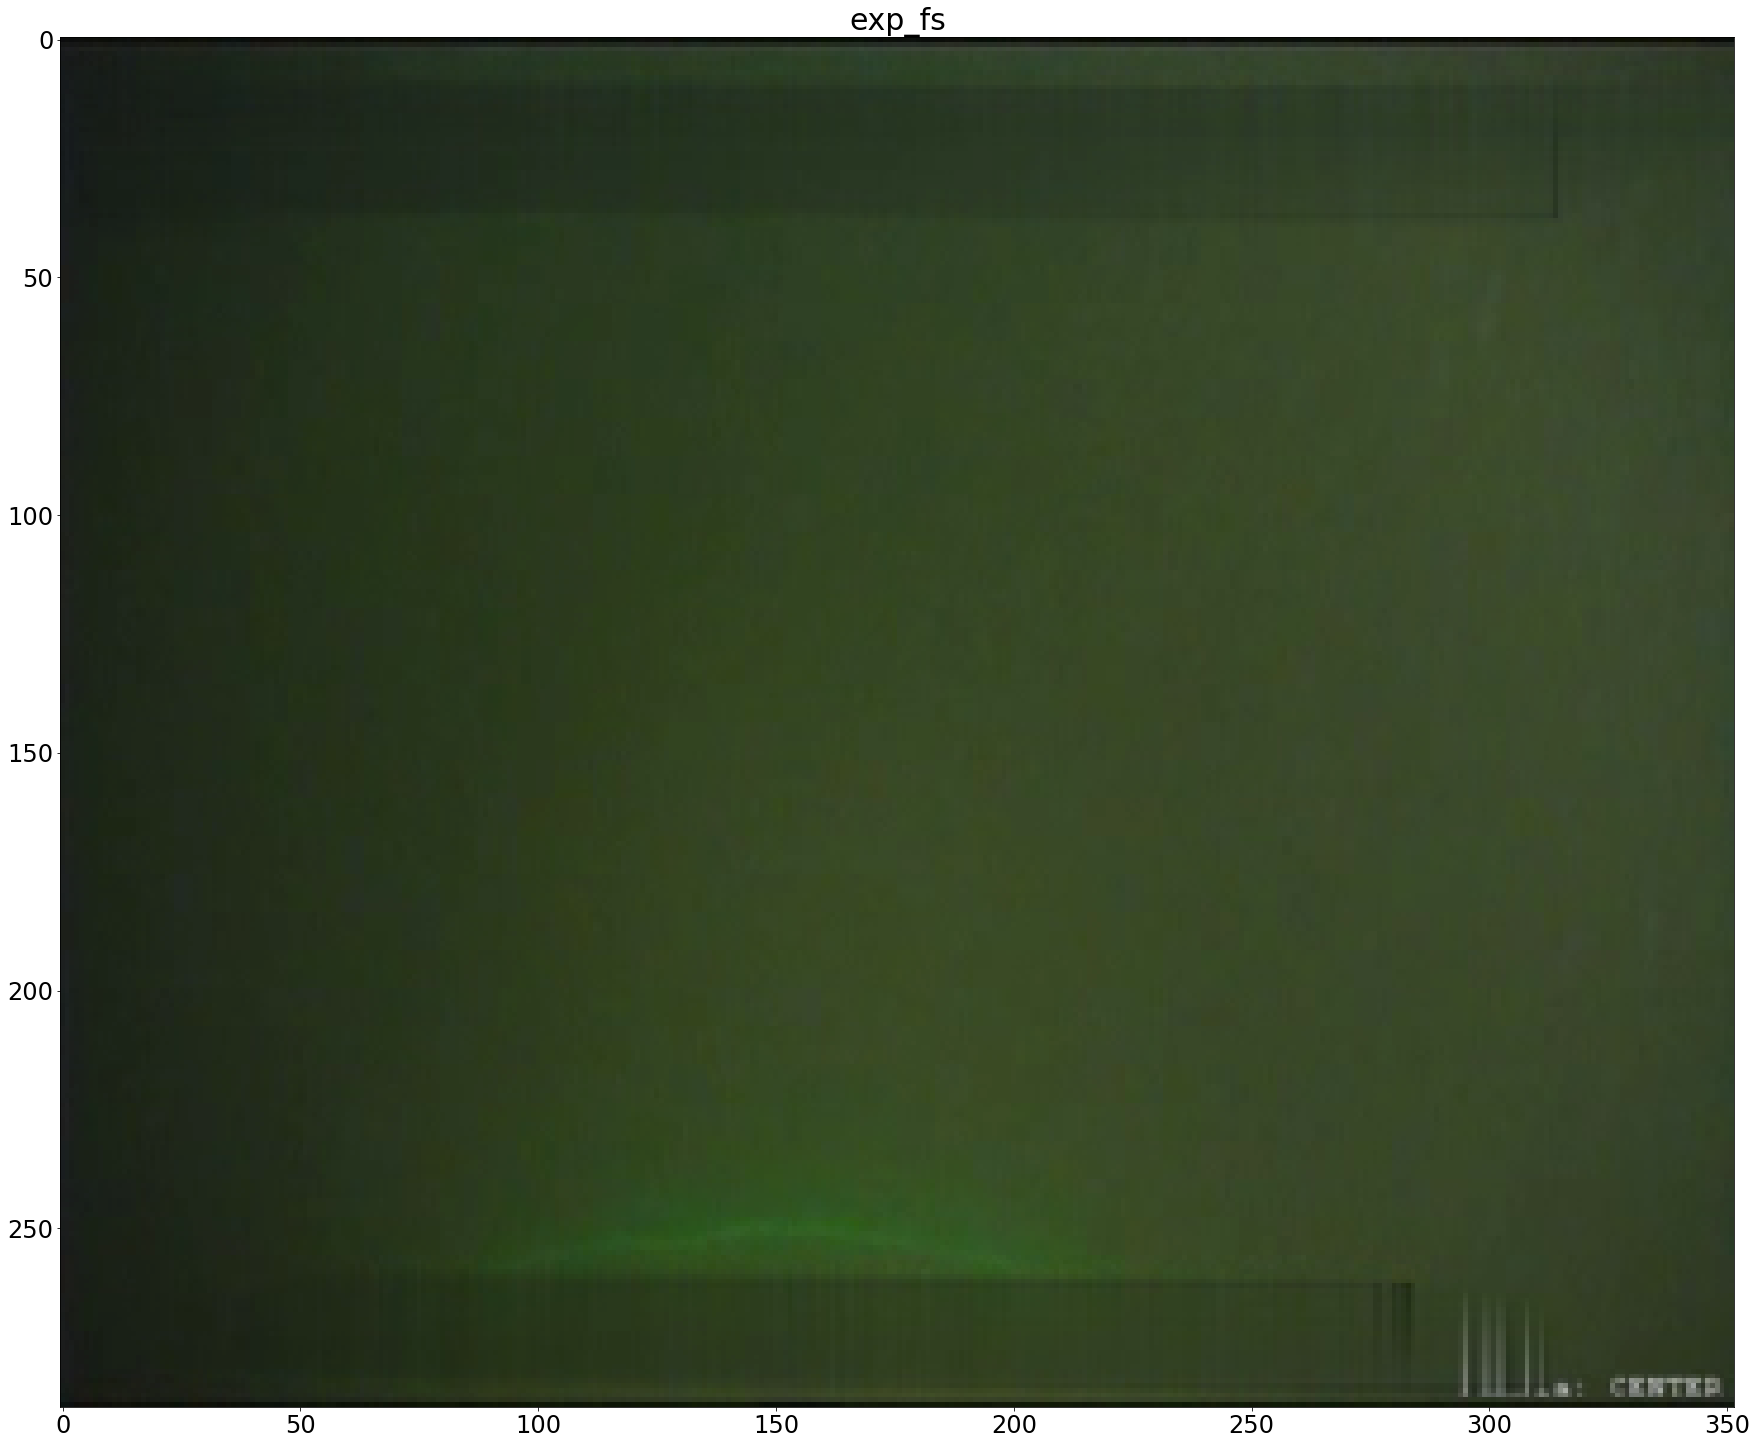

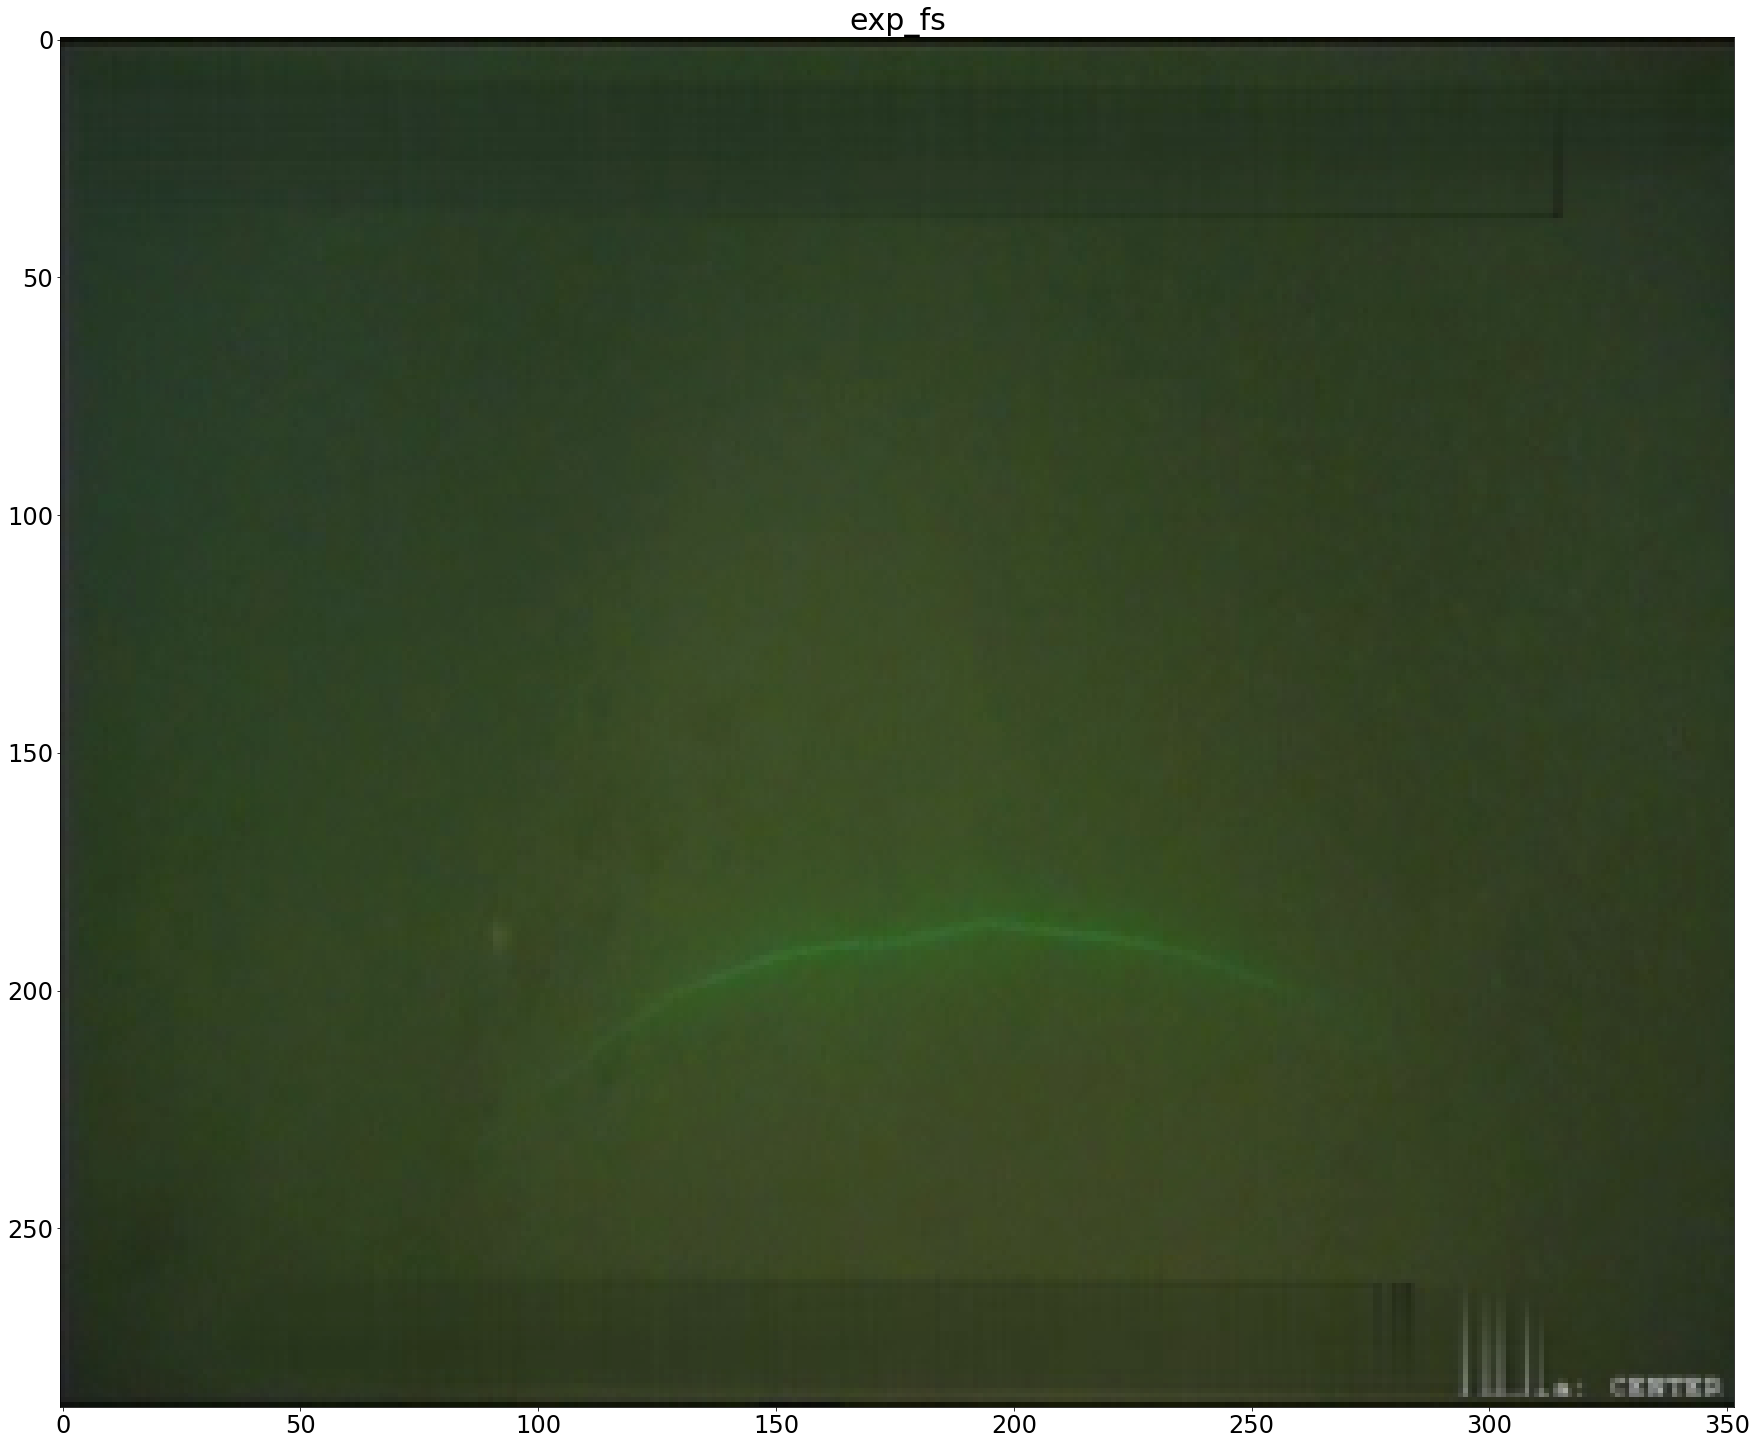

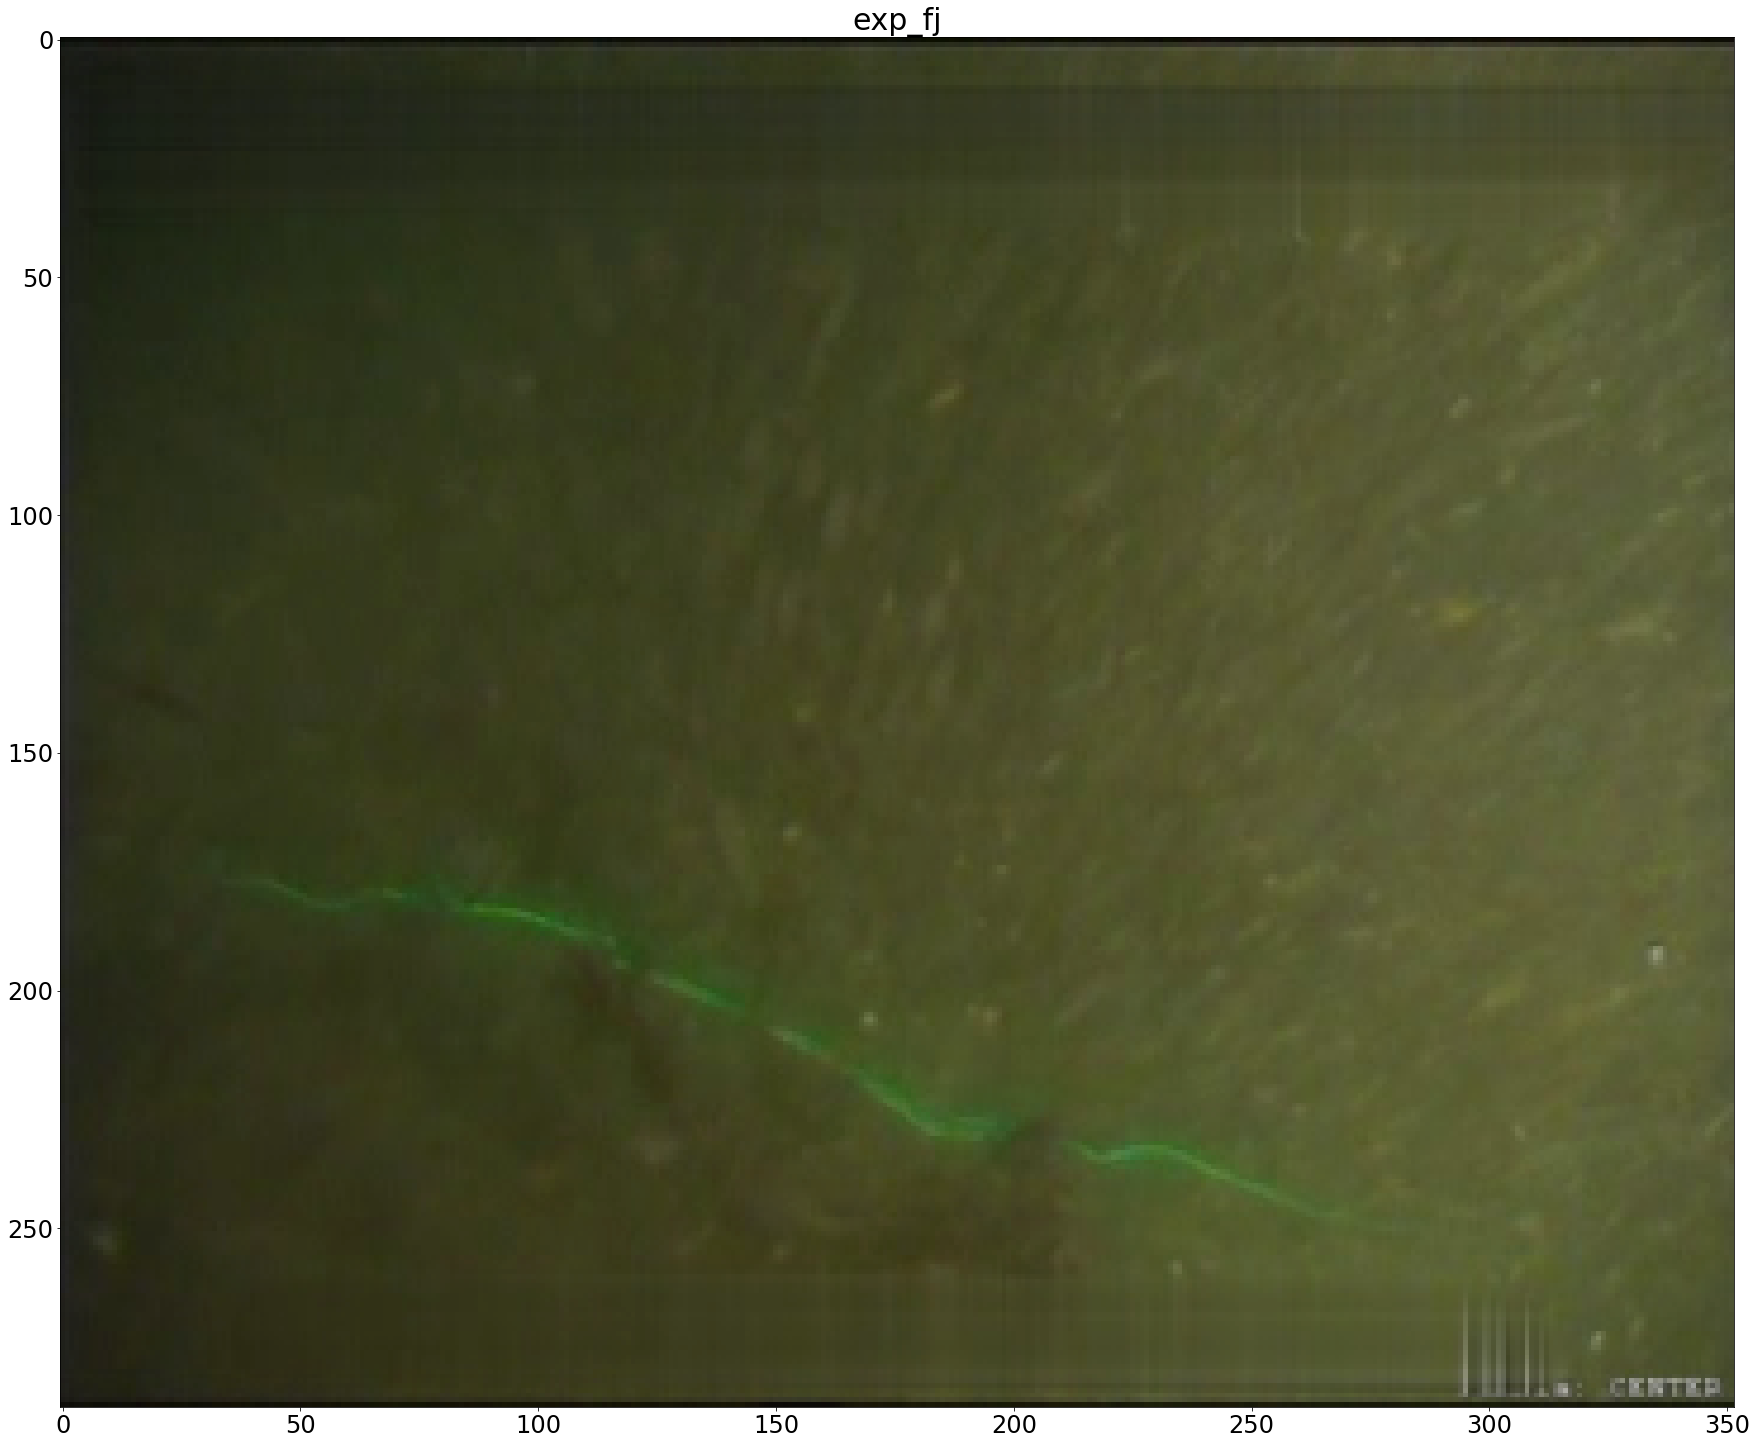

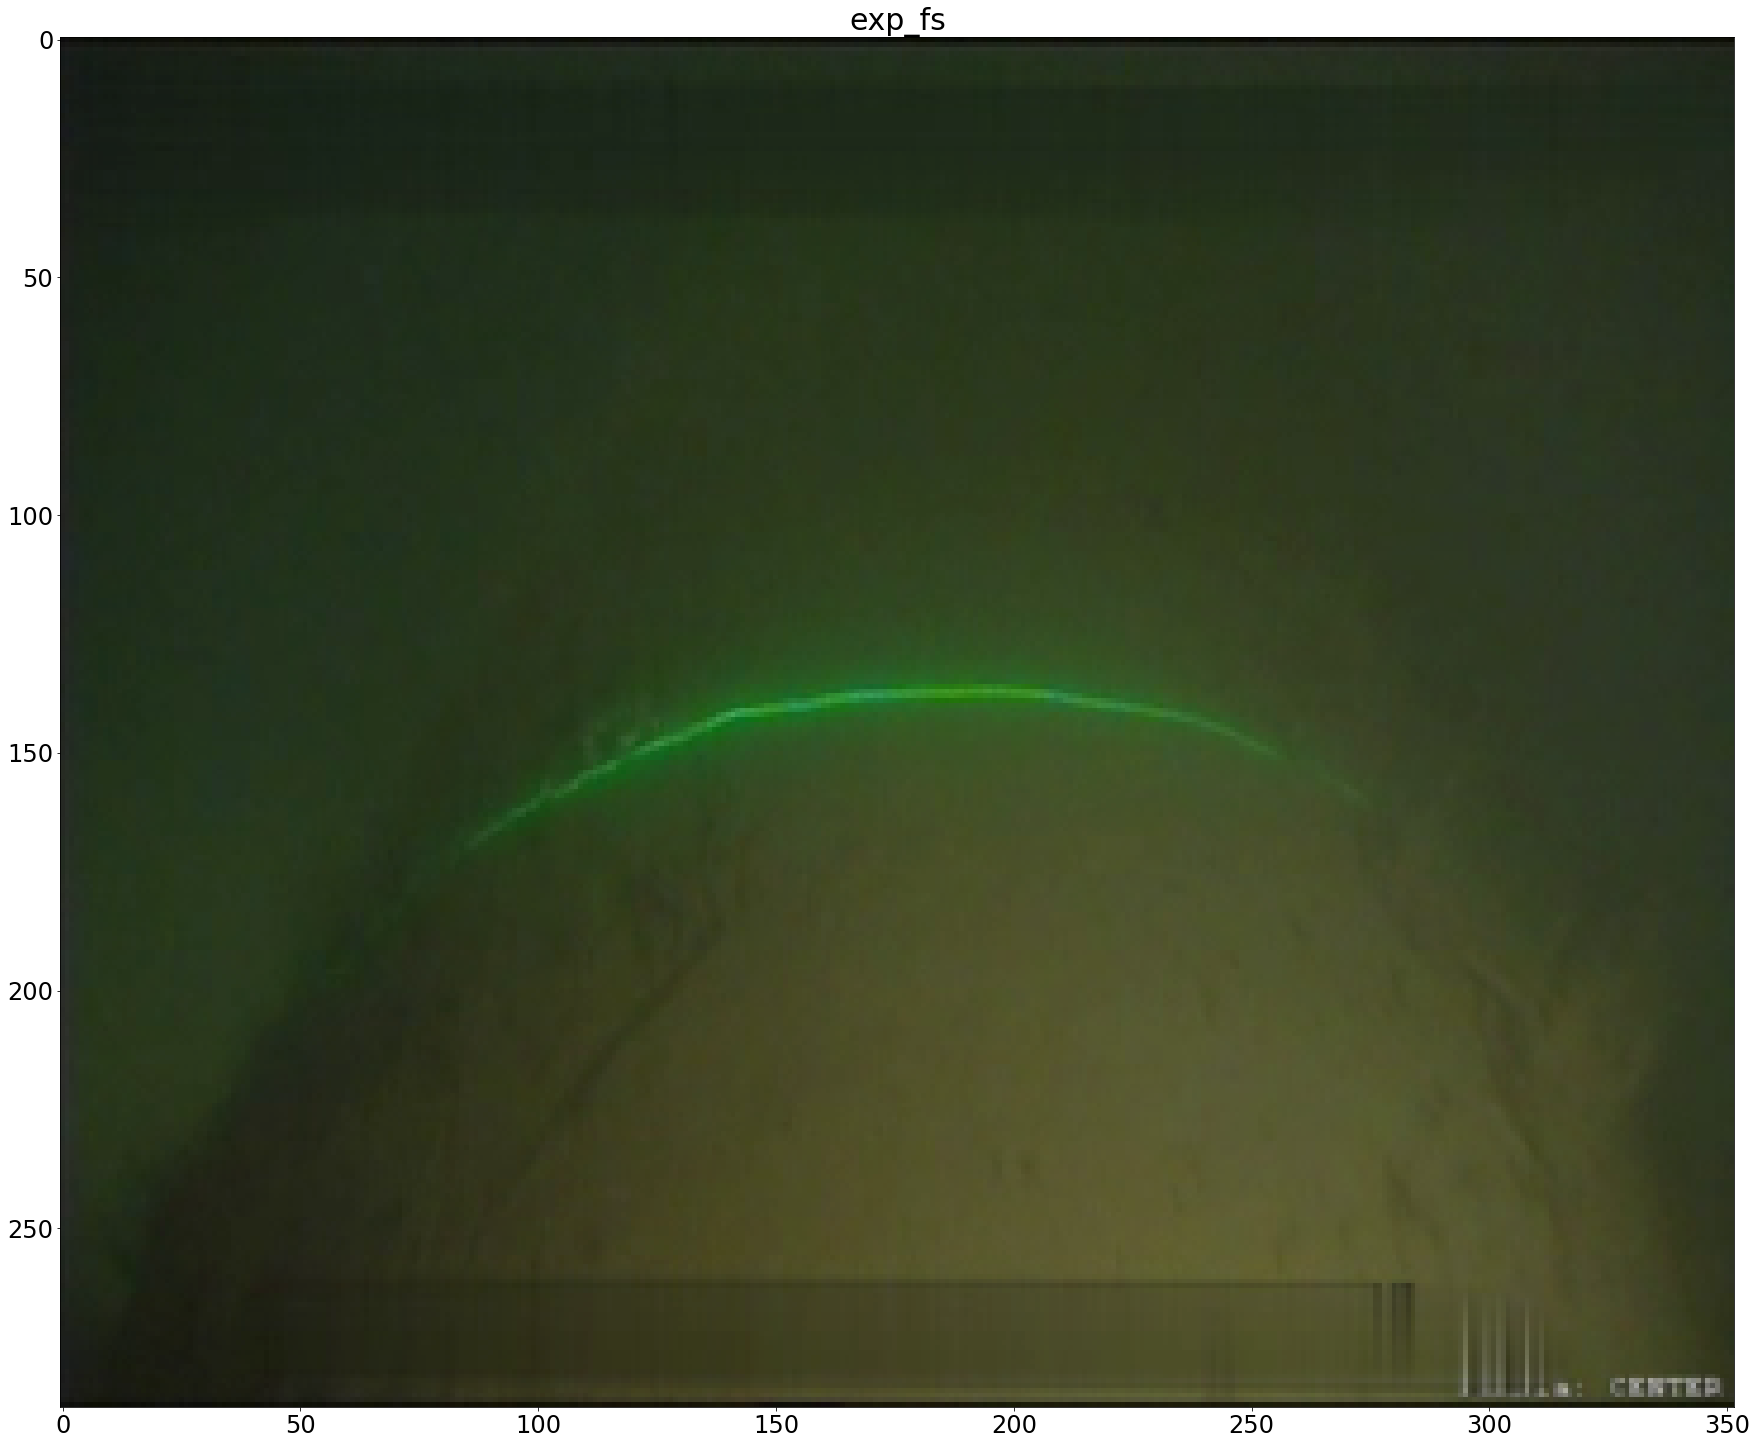

In [13]:
show_batch(valid_loader, 4)

In [ ]:
plot_predictions_actuals(valid_loader, 10, resnet, device)

In [14]:
resnet.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        y = Variable(y.float()).to(device) 
        #X = X.permute(0,2,1,3,4)
        y = y.squeeze(dim=1)
        y = y.float()
        output = resnet(X)
        y = y.detach().cpu()
        #loss = criterion(output, y)
        preds = torch.sigmoid(output)
        preds = preds.to(torch.float32) 
        preds = preds.detach().cpu()
        y_pred.append(preds)
        y_true.append(y)

In [15]:
from helpers_thresholds import *

In [16]:
y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [17]:
y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [18]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

0.9802702123096719 0.7364266151119704 0.8410303587856486
Optimal  Exposure  Threshold =  0.08634355

0.825405707890319 0.4733632862644416 0.6016724454415663
Optimal  Burial  Threshold =  0.27344146

0.5223880597014925 0.42232277526395173 0.46705587989991654
Optimal  Field Joint  Threshold =  0.41382882

0.5330882352941176 0.338785046728972 0.41428571428571426
Optimal  Anode  Threshold =  0.6828536

0.9695038689121529 0.9021601016518425 0.9346204475647214
Optimal  Free Span  Threshold =  0.71024406



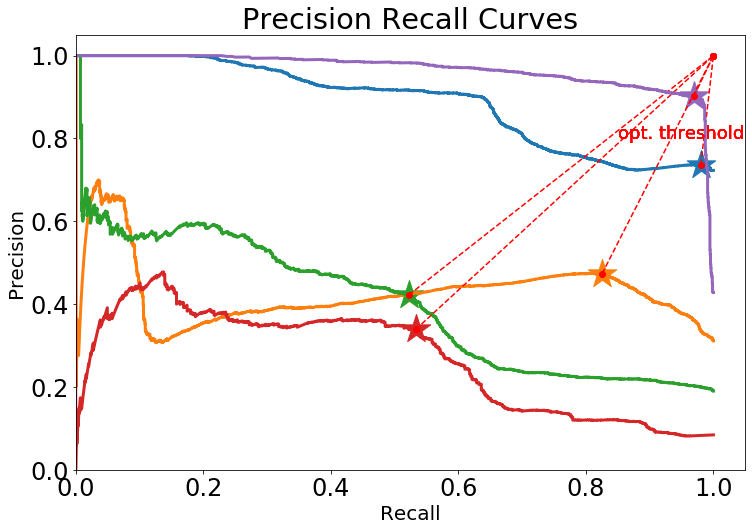

In [19]:
plot_pr_curves(0.0, y_tr, y_pr, classes)

In [20]:
thresholds = nsea_compute_thresholds(y_tr, y_pr, classes)

In [21]:
thresholds

{'Exposure': 0.08634355,
 'Burial': 0.27344146,
 'Field Joint': 0.41382882,
 'Anode': 0.6828536,
 'Free Span': 0.71024406}

## validation set

In [22]:
new_compute_metrics(y_tr, y_pr, thresholds, classes)

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.086344,0.732093,0.736427,0.980270,0.841030,151.0,1636.0,92.0,4571.0
1,Burial,0.273441,0.697209,0.473363,0.825406,0.601672,3022.0,1641.0,312.0,1475.0
2,Field Joint,0.413829,0.801860,0.422323,0.522388,0.467056,4612.0,766.0,512.0,560.0
3,Anode,0.682854,0.872868,0.338785,0.533088,0.414286,5340.0,566.0,254.0,290.0
4,Free Span,0.710244,0.953798,0.902160,0.969504,0.934620,4022.0,231.0,67.0,2130.0
5,Aggregate,NaN,0.364961,0.665736,0.875504,0.734574,NaN,NaN,NaN,NaN


## test set

In [23]:
resnet.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = Variable(y.float()).to(device) 
        #X = X.permute(0,2,1,3,4)
        y = y.squeeze(dim=1)
        y = y.float()
        output = resnet(X)
        y = y.detach().cpu()
        #loss = criterion(output, y)
        preds = torch.sigmoid(output)
        preds = preds.to(torch.float32) 
        preds = preds.detach().cpu()
        y_pred.append(preds)
        y_true.append(y)

In [24]:
y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [25]:
y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [26]:
new_compute_metrics(y_tr, y_pr, thresholds, classes)

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.086344,0.717313,0.710510,0.985727,0.825791,317.0,1829.0,65.0,4489.0
1,Burial,0.273441,0.672836,0.493716,0.842032,0.622460,2701.0,1853.0,339.0,1807.0
2,Field Joint,0.413829,0.802985,0.386846,0.547000,0.453190,4833.0,867.0,453.0,547.0
3,Anode,0.682854,0.828209,0.259908,0.447619,0.328863,5267.0,803.0,348.0,282.0
4,Free Span,0.710244,0.903284,0.885189,0.774874,0.826367,4510.0,200.0,448.0,1542.0
5,Aggregate,NaN,0.289403,0.629192,0.851343,0.700736,NaN,NaN,NaN,NaN


In [27]:
precision, recall, f1, _ = precision_recall_fscore_support(y_tr, y_pr)